# Speech Enhancement

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/speech-enhancement](https://github.com/huseinzol05/malaya-speech/tree/master/example/speech-enhancement).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.utils.read.wav('speech/khutbah/wadi-annuar.wav')
len(y), sr

(160000, 16000)

In [3]:
import IPython.display as ipd
ipd.Audio(y, rate = sr)

The speech got room echo and a bit of broken high pitch, because it recorded in mosque and maybe no limit high shelf.

### List available deep model

In [4]:
malaya_speech.speech_enhancement.available_model()

,Size (MB),MSE
resnet34-unet,97.8,0.0003
inception-v3-unet,70.8,0.0003
wavenet,70.8,0.0003


### Load deep model

Deep model trained on different augmented pitches, augmented room echo, augmented reverberance, augmented stereo depth.

In [5]:
model = malaya_speech.speech_enhancement.deep_model(model = 'resnet34-unet')

### How to enhance speech

`resnet34-unet` and `inception-v3-unet` trained on 1200 ms frames. So, we need to split our sample into smaller chunk of samples.

In [6]:
%%time

frames = list(malaya_speech.utils.generator.frames(malaya_speech.utils.astype.int_to_float(y), 1200, sr))
len(frames)

CPU times: user 1.27 ms, sys: 871 µs, total: 2.14 ms
Wall time: 1.11 ms


9

In [14]:
%%time

mels = model(frames)

CPU times: user 4.74 s, sys: 521 ms, total: 5.26 s
Wall time: 943 ms


`resnet34-unet` and `inception-v3-unet` will returned melspectrogram. So to change from melspectrogram into waveform, we need to use `malaya_speech.utils.griffin_lim.from_mel`,

```python
def from_mel(mel_):
    """
    Change melspectrogram into waveform using Librosa.

    Parameters
    ----------
    spectrogram: np.array

    Returns
    --------
    result: np.array
    """
```

In [17]:
mel = [malaya_speech.utils.griffin_lim.from_mel(mel) for mel in mels]
ipd.Audio(np.concatenate(mel), rate = sr)

In [19]:
%%time

frames = list(malaya_speech.utils.generator.frames(malaya_speech.utils.astype.int_to_float(y), 1200, sr))
mels = model(frames)
mel = [malaya_speech.utils.griffin_lim.from_mel(mel) for mel in mels]

CPU times: user 34.5 s, sys: 7.27 s, total: 41.8 s
Wall time: 8.89 s


`malaya_speech.utils.griffin_lim.from_mel` is quite expensive actually, **to speedup, you can do pipeline batching to utilize parallel processing**.

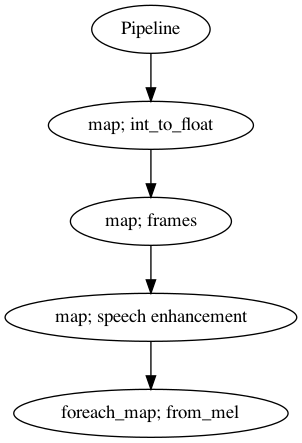

In [27]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.utils.astype.int_to_float)
    .map(malaya_speech.utils.generator.frames, frame_duration_ms = 1200)
    .map(model)
    .foreach_map(malaya_speech.utils.griffin_lim.from_mel, method = 'process', worker_size = 3)
)
p.visualize()

In [28]:
%%time

result = p.emit(y)

CPU times: user 4.76 s, sys: 447 ms, total: 5.21 s
Wall time: 8.2 s


In [29]:
result.keys()

dict_keys(['int_to_float', 'frames', 'speech-enhancement', 'from_mel'])

In [30]:
ipd.Audio(np.concatenate(result['from_mel']), rate = sr)